# Integrantes: 
# Bruno Mazetti Saito - 11221838
# João Felipe Lobo Pevidor - 11221992
# Patrick Silva Souza - 11221821
# Willian Hiroshi Takihi - 11221755

In [17]:
using Plots
using StatsPlots
using CSV
using DataFrames
using Query
using CategoricalArrays

In [18]:
path = pwd()
function load_csv(path)
    df = DataFrame(CSV.File(path*"/all_files.csv"))
    return df
end

load_csv (generic function with 1 method)

In [19]:
function confidence_interval(std)
    # N = 10
    return std/sqrt(10)*1.96
end


confidence_interval (generic function with 1 method)

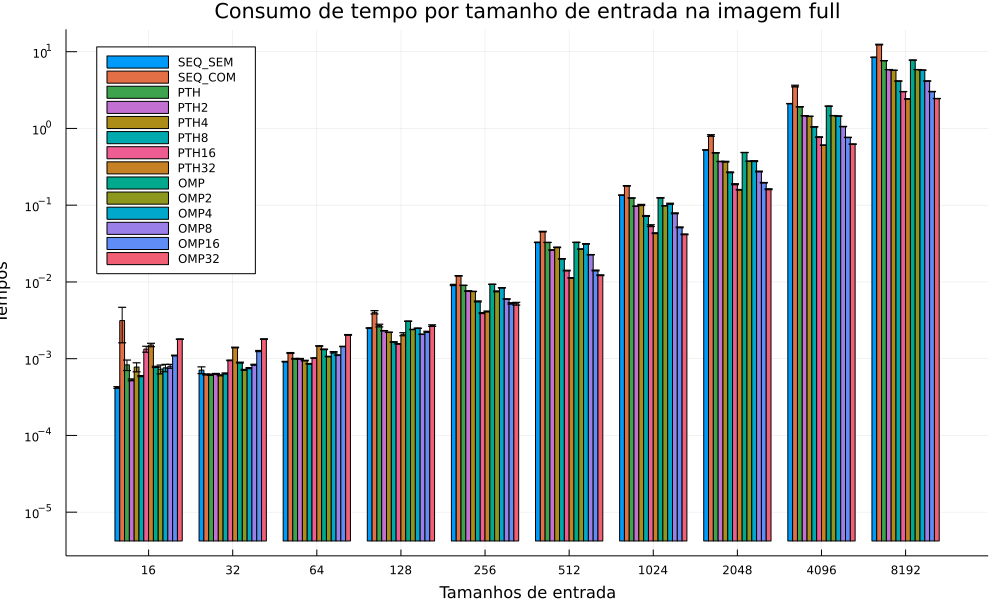

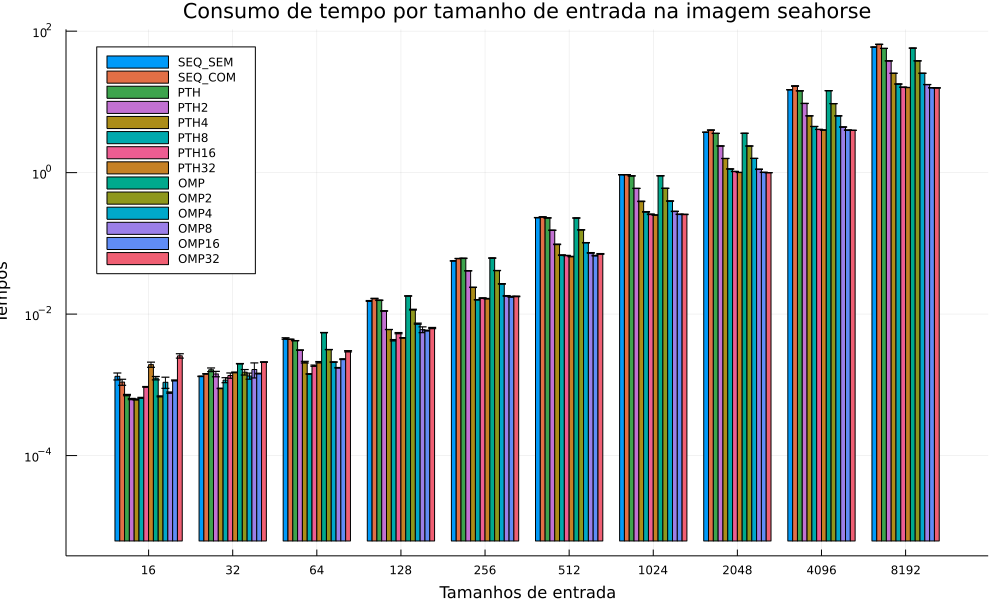

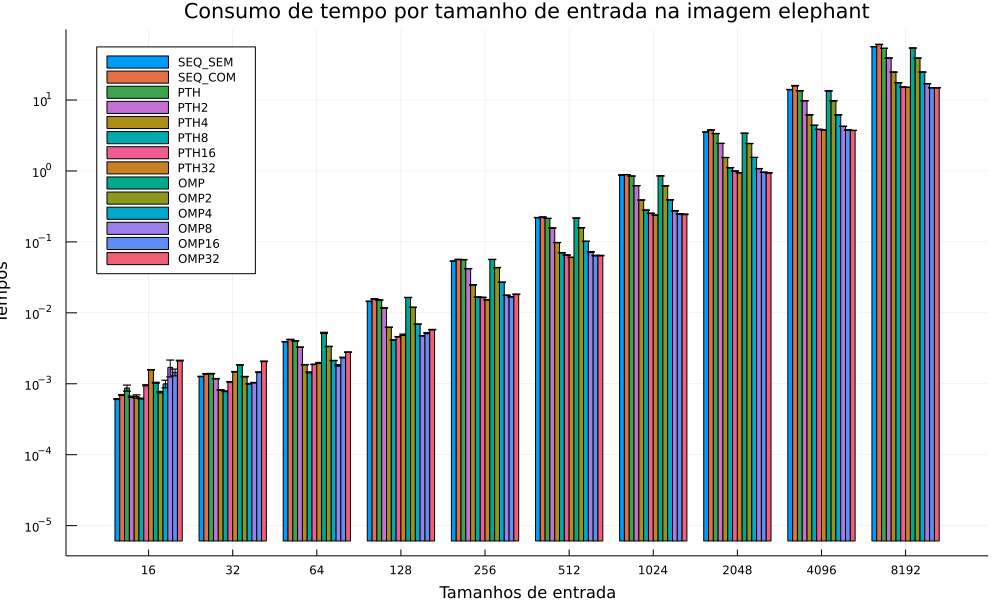

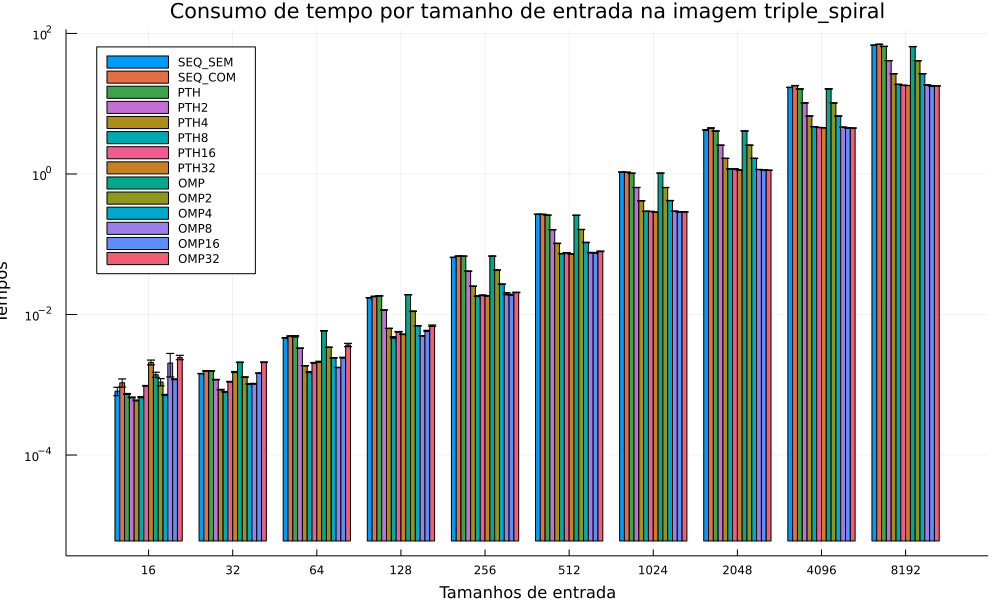

In [20]:
# plot error -> yerror

df = load_csv(path)

function create_graph_for_size(image)
    sort!(df, [:Imagem, :Tamanho, :Threads])

    selected = @from i in df begin
        @where i.Imagem==image
        @orderby i.Tamanho, descending(i.Programa)
        @select {i.Tamanho, i.Tempo, i.Desvio, i.Imagem, i.Threads, i.Programa}
        @collect DataFrame
    end

    times = convert(Array, selected[:, 2])
    desvios = convert(Array, selected[:, 3])
    yerror = []
    for desvio in desvios
        append!(yerror, confidence_interval(desvio))
    end
    labels = ["SEQ_SEM", "SEQ_COM"]
    for j in ["PTH", "OMP"]
        push!(labels, String(j))
        for i in ["2", "4", "8", "16", "32"]
          s = j*i
          push!(labels, s)  
        end

    end

    sx = CategoricalArray(repeat(labels, outer = 10))
    levels!(sx, labels)

    sizes = ["16", "32", "64", "128", "256", "512", "1024", "2048", "4096", "8192"]
    sizesx = CategoricalArray(repeat(sizes, inner = 14))
    levels!(sizesx, sizes)

    display(groupedbar(sizesx, times, group = sx, yerr=yerror, yaxis=:log,
            ylabel = "Tempos", xlabel = "Tamanhos de entrada", 
            title = "Consumo de tempo por tamanho de entrada na imagem "*image, size=(1000,600), legend=:topleft))
end

images = ["full", "seahorse", "elephant", "triple_spiral"]
for img in images
    create_graph_for_size(img)
end

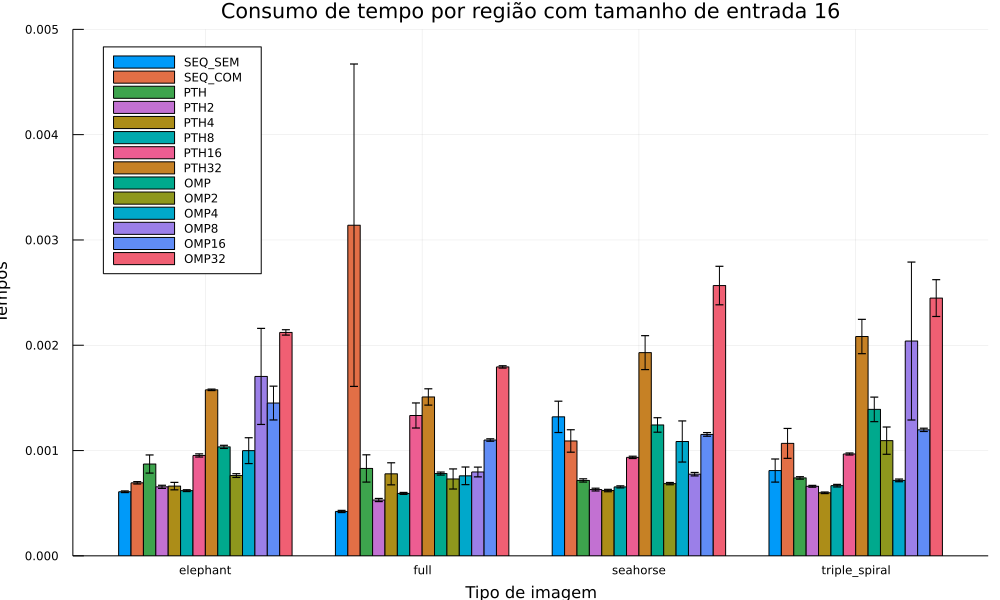

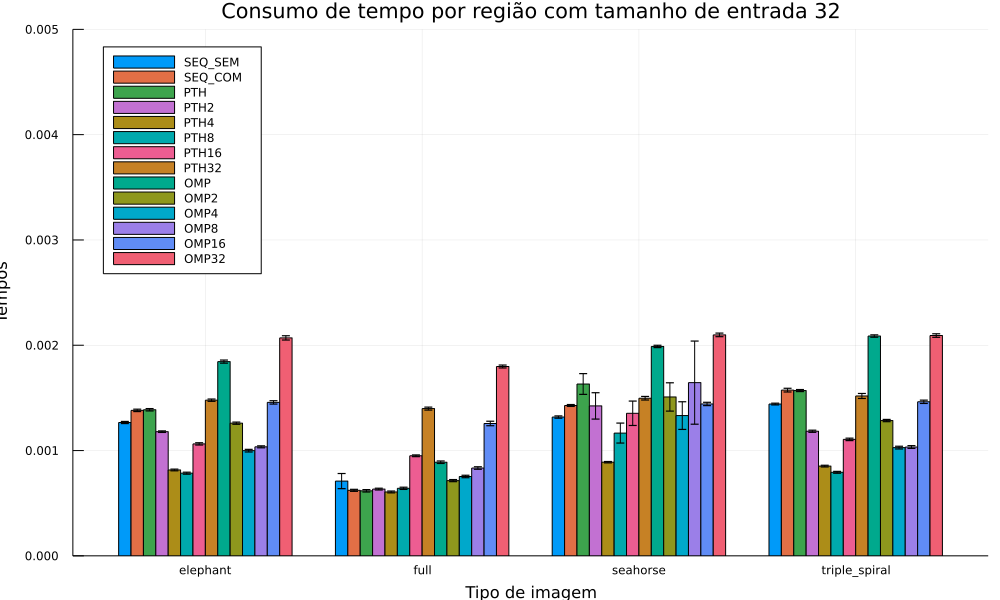

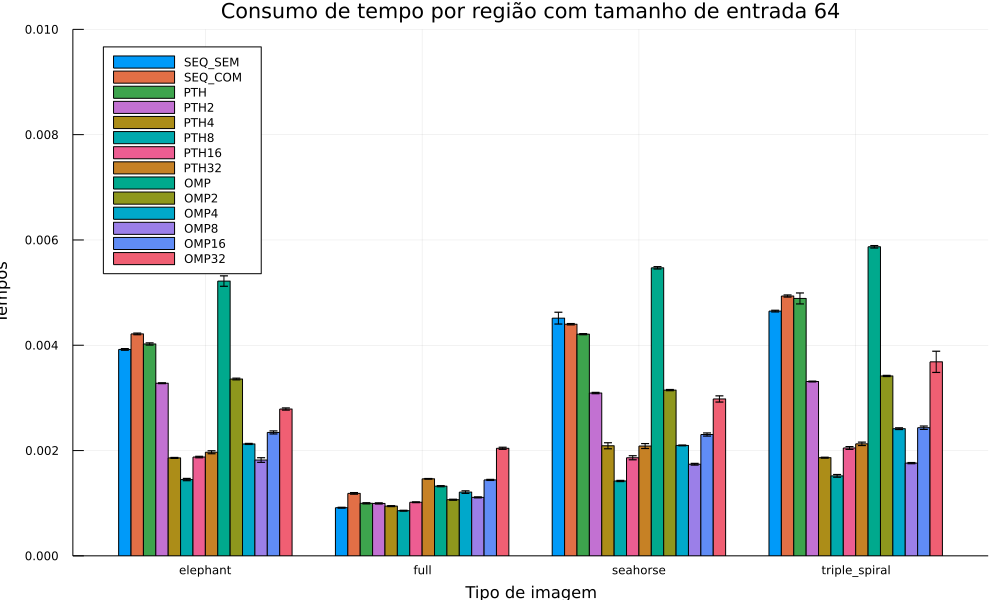

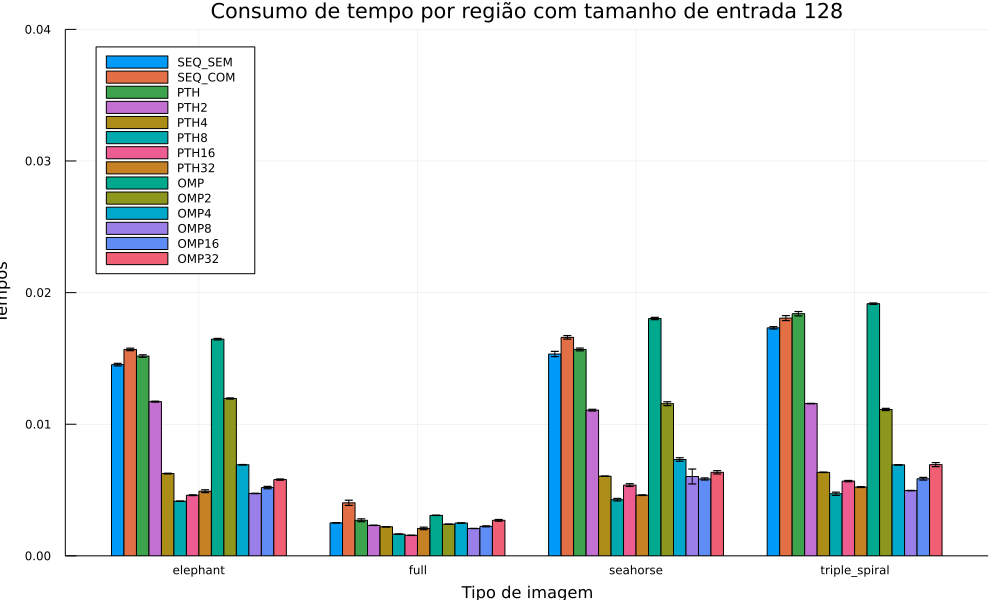

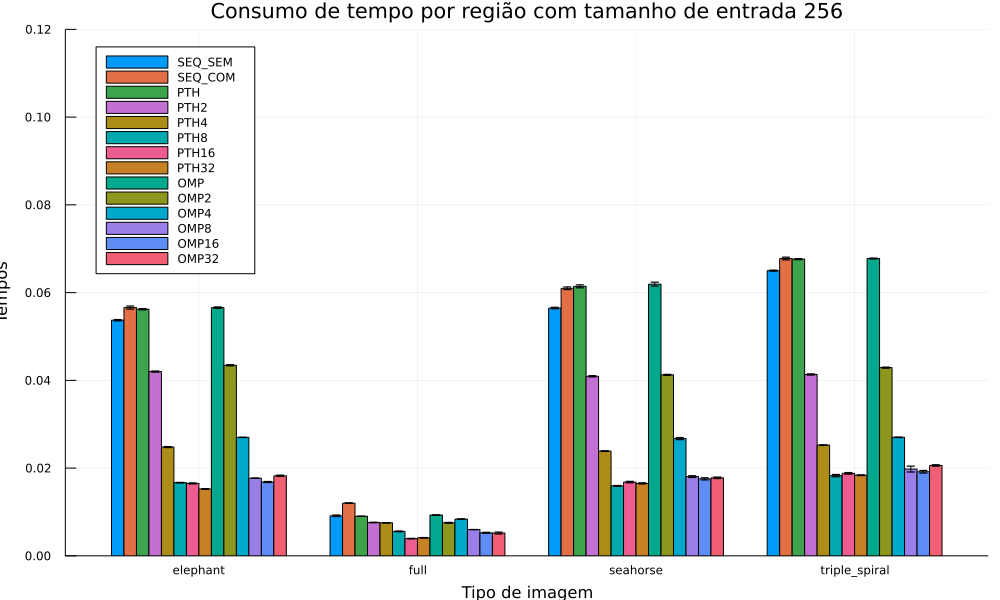

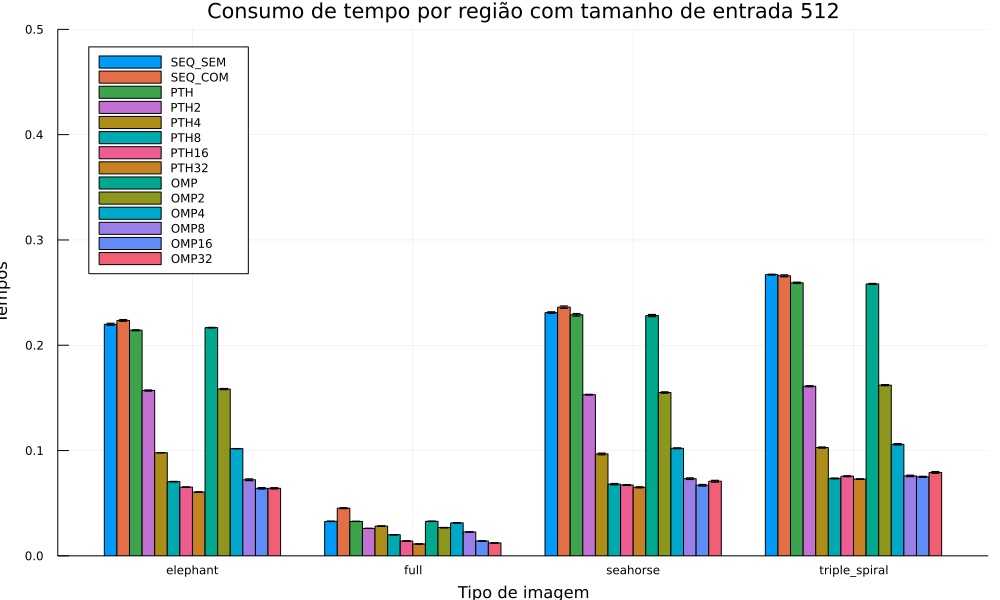

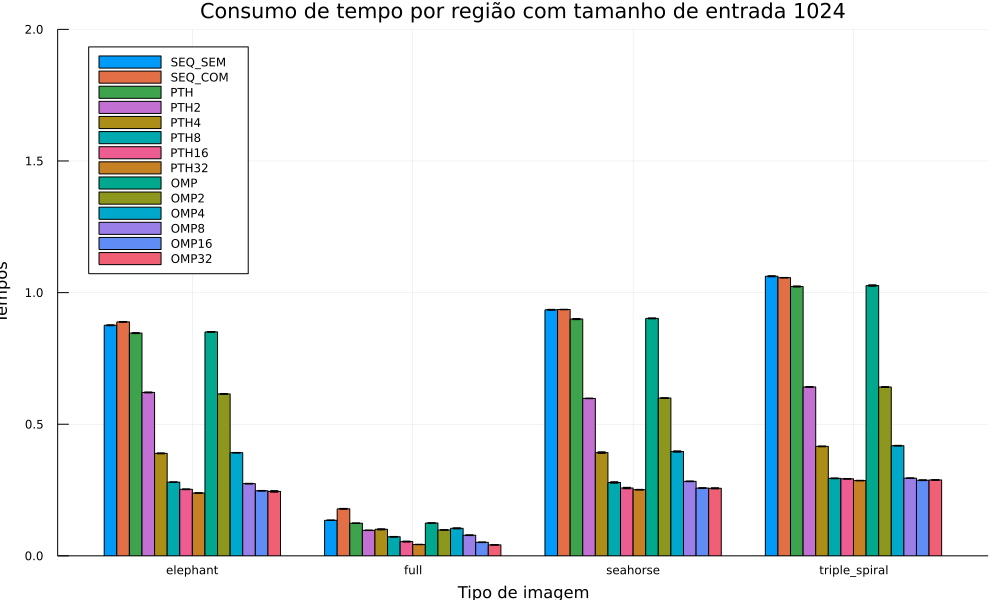

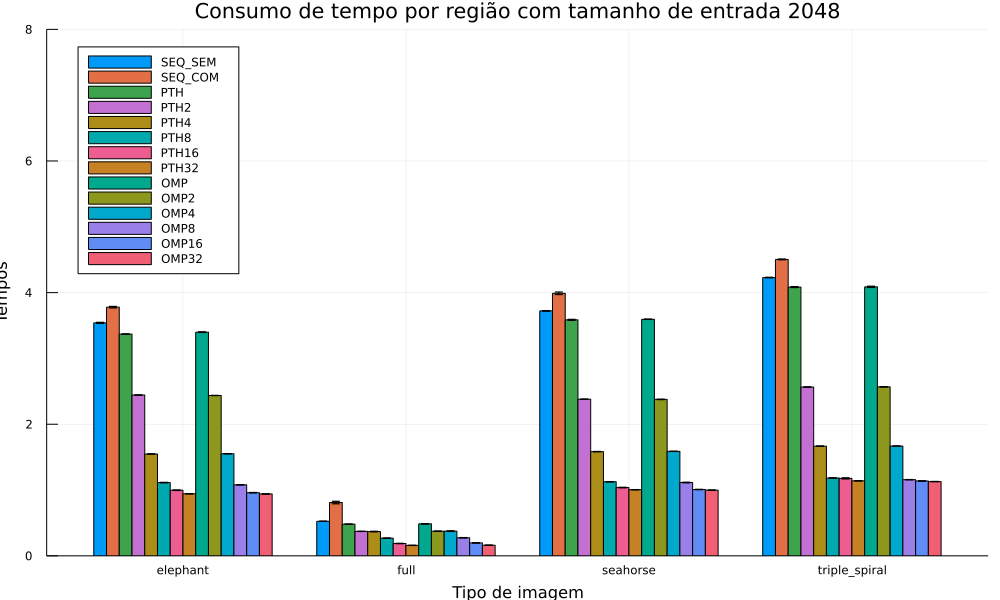

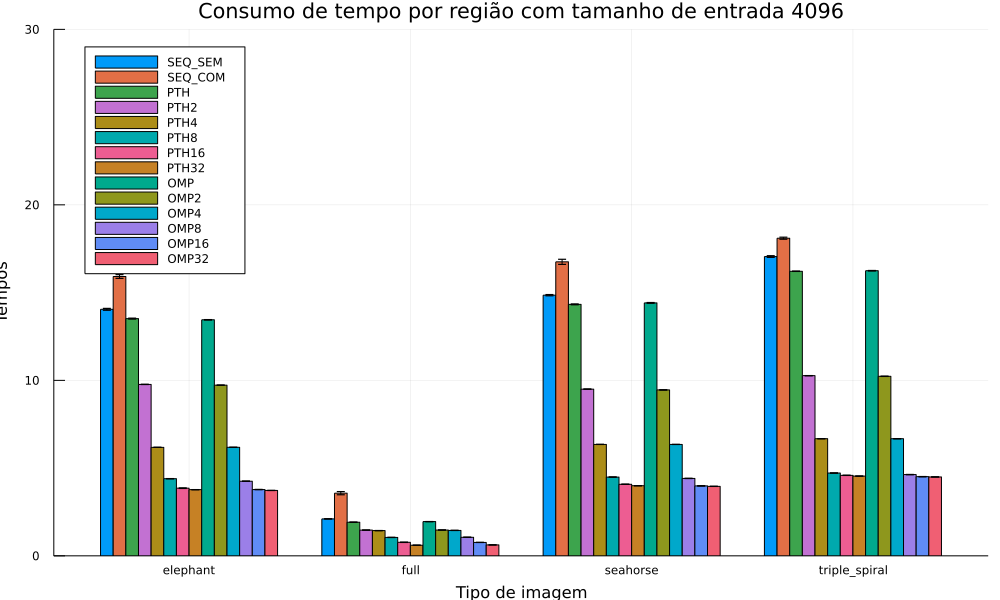

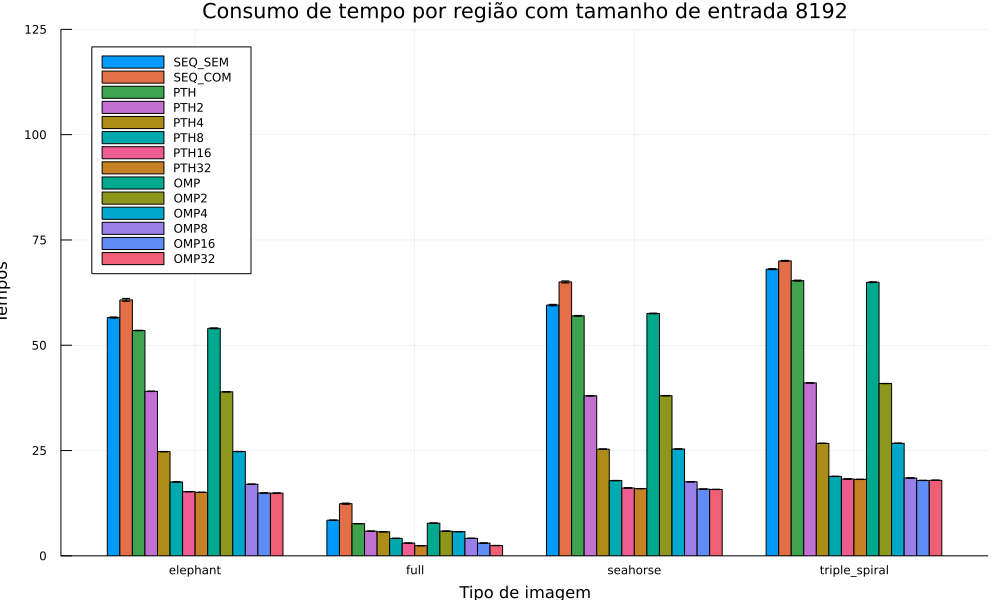

In [26]:
function create_graph_for_region(sz, lim)
    sort!(df, [:Imagem, :Tamanho, :Threads])
    selected = @from i in df begin
        @where i.Tamanho==sz
        @orderby i.Imagem, descending(i.Programa)
        @select {i.Tamanho, i.Tempo, i.Desvio, i.Imagem, i.Threads, i.Programa}
        @collect DataFrame
    end

    times = convert(Array, selected[:, 2])
    desvios = convert(Array, selected[:, 3])
    yerror = []
    for desvio in desvios
        append!(yerror, confidence_interval(desvio))
    end
    labels = ["SEQ_SEM", "SEQ_COM"]
    for j in ["PTH", "OMP"]
        push!(labels, String(j))
        for i in ["2", "4", "8", "16", "32"]
          s = j*i
          push!(labels, s)  
        end

    end

    sx = CategoricalArray(repeat(labels, outer = 4))
    levels!(sx, labels)

    sizes = ["elephant", "full", "seahorse", "triple_spiral"]
    sizesx = CategoricalArray(repeat(sizes, inner = 14))
    levels!(sizesx, sizes)
    display(groupedbar(sizesx, times, group = sx, yerr=yerror, 
            ylabel = "Tempos", xlabel = "Tipo de imagem", 
            title = "Consumo de tempo por região com tamanho de entrada "*string(sz),
            size=(1000,600), legend=:topleft, ylim=(0,lim)))
end
sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
lims = [0.005, 0.005, 0.01, 0.04, 0.12, 0.5, 2, 8, 30, 125]

for i in 1:length(sizes)
    create_graph_for_region(sizes[i], lims[i])
end

# **ANÁLISE DOS RESULTADOS**

## A análise do comportamento das variáveis "Tamanho da Imagem" (Tamanho de Entrada), "Número de Threads" e "Operações de I/O e Alocações de Memória" será feita utilizando apenas o gráfico abaixo, o qual se refere apenas ao cálculo da imagem "Full", visto que os comportamentos dos demais gráficos referentes ao cálculo das imagens restantes são parecidos. É bom ressaltar que a variável "Tempos" está representada em escala logarítmica para facilitar a visualização.

## É possível observar que, no geral, o tempo para execução do programa é proporcional ao tamanho da imagem calculada, por calcular mais pixels para a formação da imagem final. Isso é mais evidente a partir do tamanho de entrada 256.

## Vemos que o tempo necessário para o cálculo da imagem com tamanhos de entrada menores acaba sendo maior quando utilizado mais threads, pois o tempo gasto para divisão do trabalho entre as threads é maior que os cálculos da imagem em si, portanto, nesses casos, não é vantajoso utilizar threads. Porém, em tamanhos de entrada maiores, observa-se que o tempo gasto é maior pelos programas sequenciais e, quanto o maior número de threads utilizado, menor o tempo de execução.

## O tempo adicional resultante das operações de I/O e alocação de memória também é proporcional ao tamanho da imagem calculada. 

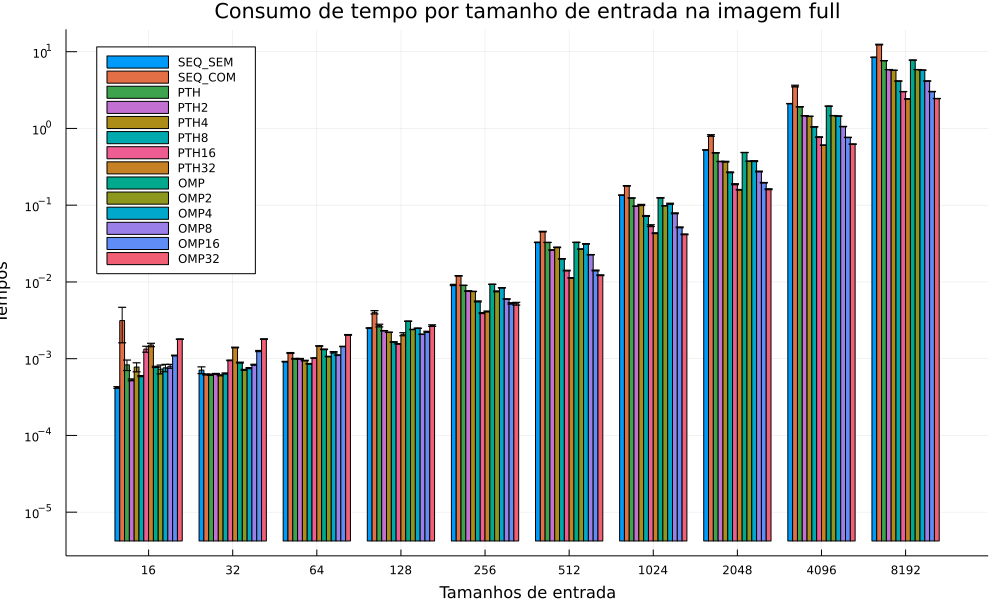

In [22]:
create_graph_for_size("full")

## Analisemos o comportamento da variação da região do Conjunto Mandelbrot com base no gráfico abaixo.

## Os tempos de execução são bem semelhantes em relação a formação das imagens "Elephant", "Seahorse" e "Triple_Spiral", pois elas demandam mais computação devido ao seu nível de detalhes. Além disso, independente da região calculada, as threads diminuem o tempo de execução do programa.

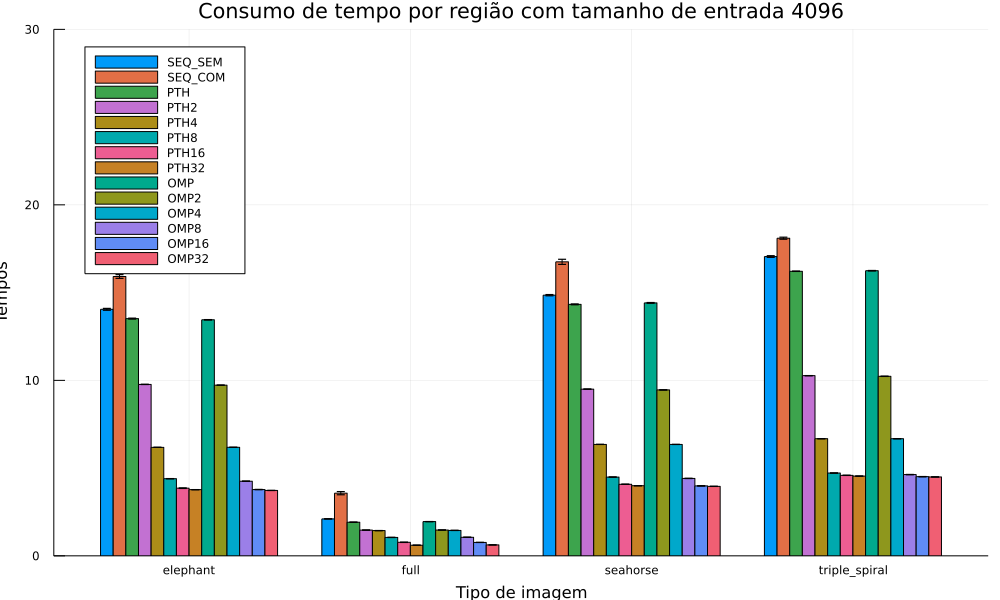

In [27]:
create_graph_for_region(4096, 30)

## OBS: Nos códigos fonte da pthread e OMP, utilizou-se a variável de ambiente OMP_NUM_THREADS para limitar o número de threads utilizada.